# Rate Model of 1 Excitatory and 3 Inhibitory populations
4 Wilson-Cowan style populations with feedforward input from thalamus and recurrent connections.

Following the 2 population model in Natan et al 2015, and 4 population model in Litwin-Kumar et al 2016

Rough outline:
0. Make general model with 4x4 weight matrix
1. Set 2 of the I population weights to 0 and reproduce result from Natan

UPDATE: I'm not sure how much it is worth to try to reproduce this network, because it doesn't easily generalize to the Litwin-Kumar 4 population network. There are some weird specificities in here, like the inhibitory transfer function, and the precomputed input current and opto current. One thing that is probably useful is the synaptic adaptiation. So I'm going to skip directly to the Litwin-Kumar network here.

UPDATE 2: the rate network in Litwin-Kumar is the linearized network...

2. Reproduce steady-state 2 population result from Litwin-Kumar
3. Reproduce steady-state 4 population result from Litwin-Kumar
4. Add adaptive synapses to recurrent circuit
5. Extend to reproduce experimental findings in Natan, probably need to tile the circuit

In [5]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [210]:
def network(r, t, J, T):    
    drdt = -r + transfer_func(mu(t) + np.dot(J,r))
    return drdt/T

def linear_network(r, t, W, T):    
    # linearized network
    drdt = (np.dot(W,r)-r + constant_b(t))/T
    return drdt

def transfer_func(curr_input):
    # transfer function from current to firing rate    
    return curr_input**2

def mu(t):
    # time-varying input to the network
    return constant_b(t)

def constant_b(t):
    # it's a convenient trick so we can index input by time, but it seems
    # the integration is time asynchronous, i.e. at uneven time steps
    if t<=0.1:
        return 0
    else:
        return np.array([0,0,0,5]).T

def plot_rates(t,r,W):    
    c_ord = [0,2,1,4]
    labels = ['E','PV','SOM','VIP']
    plt.subplot(2,1,1)
    for i in range(4):
        plt.plot(t,r[:,i],color=CKEYS[c_ord[i]],label=labels[i])
        
    plt.ylabel('Firing Rate (Hz)')
    plt.legend()
    
    plt.subplot(2,1,2)
    Ie, Ii = return_EI(r,W)
    plt.plot(t,Ie, 'gray', label='E Total')
    plt.plot(t,Ii, 'k', label='I Total')
    plt.xlabel('Time (s)')
    plt.ylabel('Current')
    plt.legend()
    
    
# def return_EI(r, W):
#     Ie = np.outer(r[:,0],W[:,0]).sum(1)
#     Ii = np.zeros_like(Ie)
#     for i in range(1,r.shape[1]):
#         Ii+= np.outer(r[:,i],W[:,i]).sum(1)
#     return Ie-Ie[0], Ii-Ii[0]

def return_EI(r, W):
    curr = W[0,:]*r
    Ie, Ii=curr[:,0], -curr[:,1:].sum(1)
    return Ie-Ie[0],Ii-Ii[0]

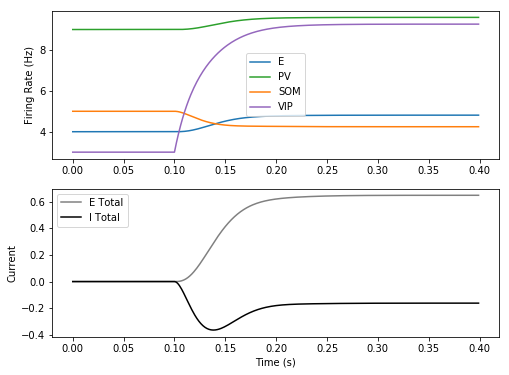

In [211]:
r0 = np.array([4,9,5,3]).T
T, dt = 0.4, 0.001
t = np.arange(0,T,dt)
W_EE = 0.8
W = np.array([[W_EE, -1, -1, 0],
              [1, -1, -0.5, 0],
              [1, 0, 0, -0.25],
              [1, 0, -0.6, 0]])

taus = np.array([0.02, 0.02, 0.02, 0.02]).T
r = integrate.odeint(linear_network, np.zeros(4), t, args=(W, taus))
plt.figure(figsize=(8,6))
plot_rates(t,r+r0, W)

(400, 4)

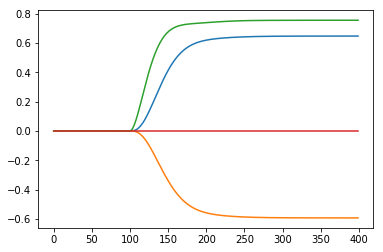

In [209]:
np.dot(r,W[0,:])
W[0,:].shape, r.shape
plt.plot(W[0,:]*r)
(W[0,:]*r).shape